# KMNIST

## Importing the libraries

In [4]:
import tensorflow as tf
import pathlib
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
from torchmetrics.classification import Accuracy
import numpy as np
import os
from torch.utils.data import Subset


# defining the image transformations
transform = transforms.Compose([

    # Converting the image to PyTorch tensors
    transforms.ToTensor(),

    # Performing the Normalization 
    transforms.Normalize((0.5,), (0.5,))


])


# Loading the datasets

train_set = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.KMNIST(root='./data', train = False, download=True, transform=transform)



# Creating the PyTorch dataloaders for batch processing 
# Shuffling the data for training because we can get the different combinations of samples for each epoch so the model learns well
# Shuffling for test data is set to False because there is no learning.
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data  = DataLoader(test_set,batch_size=64, shuffle=False)


/Users/manidatta/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Designing a Baseline Model

In [355]:
# defining the Classification class

class KMNIST(nn.Module):

    def __init__(self,n_channels, n_classes):
        super(KMNIST,self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        # Declaring all the layers which will be used in this model
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # after passing to above two pooling layers the image size will be reduced to 3 x 3
        self.fc1  = nn.Linear(512 *3 *3, 512)
        self.fc2  = nn.Linear(512,10)

        self.relu = nn.ReLU()

    
    # feed forward model 

    def forward(self, x):
        # Applying the five convolutional layers passing through ReLU activation function and pooling layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        
        # Flattening 
        x = torch.flatten(x, 1)

        # Fully connected layers passing through ReLU activation function
        x = F.relu(self.fc1(x))  
        x = self.fc2(x) 
        
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the Model

In [356]:
def Train(train_data,model_name,n_classes):
 epochs = 5

 save_path = "models/"
 os.makedirs(save_path, exist_ok=True) 

 n_channels = 1
 

 # Initializing the model
 model = KMNIST(n_channels=n_channels,n_classes=n_classes).to(device)
    
 # Defining the Stochastic Gradient descent optimizer
 sgd_optimizer = optim.SGD(model.parameters(), lr=0.01)
 # defining the Accuracy Metric
 accuracy_metric = Accuracy(task="multiclass", num_classes=n_classes).to(device) 

 # Defining the Cross Entropy loss function
 loss_function = nn.CrossEntropyLoss().to(device)


 # defining the loss 
 losses =[]

 for epoch in range(epochs):
     # initiaizing the loss for each batch 
     batch_losses =[]

     # Resetting the accuracy metric for each epoch
     accuracy_metric.reset()
        
     # iterating over each batch
     for images, labels in train_data:
         images , labels = images.to(device) , labels.to(device)
         output = model(images)
                         
         # calculating the loss
         loss = loss_function(output, labels)

         # Making all the gradients to zero, so that weights are updated using the current gradients not previous ones
         sgd_optimizer.zero_grad()

         # backpropogration
         loss.backward()

         # updating the weights 
         sgd_optimizer.step()

            

         # appending the loss of the current batch
         # .item() will convert the loss from tensor to float
         batch_losses.append(loss.item())

         # updating the accuracy metrics for currrent batch
         accuracy_metric.update(output,labels)

     # Calculating the losses for and accuracy for epoch which includes all the batches
     train_loss = np.mean(batch_losses)
     train_accuracy = accuracy_metric.compute().item()
     losses.append(train_loss)

     print(f" Epoch [{epoch +1}/{epochs}], Loss: {train_loss:.4f} , Accuracy: {train_accuracy *100:.2f}% \n")

 # saving the model for each epoch size
 model_filename = f"{save_path}{model_name}_model_epoch_{epochs}.pth"
 torch.save(model.state_dict(), model_filename)
 print(f"Model saved: {model_filename}\n")

In [357]:
Train(train_data,"Baseline Model",10)

 Epoch [1/5], Loss: 2.2942 , Accuracy: 22.12% 

 Epoch [2/5], Loss: 0.9630 , Accuracy: 71.43% 

 Epoch [3/5], Loss: 0.2796 , Accuracy: 91.20% 

 Epoch [4/5], Loss: 0.1661 , Accuracy: 94.90% 

 Epoch [5/5], Loss: 0.1156 , Accuracy: 96.47% 

Model saved: models/Baseline Model_model_epoch_5.pth



## Testing the Baseline Model

In [446]:
from sklearn.metrics import classification_report
def evaluate(test_data,model_path,class_names):
   
   # Reinitializing the model
   model = KMNIST(n_channels=1,n_classes=10).to(device)


   # Loading the trained weights
   model.load_state_dict(torch.load(model_path))

   model.eval()
   model = model.to(device)
    
   # defining the Accuracy Metric
   accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device) 

   y_true = []
   y_pred = []

   # No gradient calculations are required
   with torch.no_grad():
    for images, labels in test_data:
        images , labels = images.to(device) , labels.to(device)

        outputs = model(images)

        predictions = torch.argmax(outputs, axis =1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

        accuracy_metric.update(predictions, labels)

   test_accuracy = accuracy_metric.compute().item()
   print(f"Test accuracy of the Model: {test_accuracy * 100:.2f}%")

   print("Classification Report:")
   print(classification_report(y_true, y_pred, target_names=class_names))

In [447]:
evaluate(test_data,"models/Baseline Model_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 87.62%
Classification Report:
              precision    recall  f1-score   support

           o       0.96      0.88      0.92      1000
          ki       0.97      0.81      0.89      1000
          su       0.81      0.87      0.84      1000
         tsu       0.89      0.96      0.92      1000
          na       0.67      0.94      0.78      1000
          ha       0.85      0.93      0.89      1000
          ma       0.89      0.92      0.90      1000
          ya       0.99      0.77      0.87      1000
          re       0.89      0.94      0.92      1000
          wo       0.99      0.74      0.84      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



## Training the model with 25% , 50% and 75% of Total Training data

In [363]:
# defining the function which returns the percentage of balanced class data
from collections import defaultdict
def balanced_class_partial_train_data(dataset,percent):

    # initializing the empty dictionary, it is used to the store the labels and indices of the data
    class_indices = defaultdict(list)

    # Organizing the indices by class
    for idx, (_,label) in enumerate(dataset):
        class_indices[label].append(idx)

    percent_indices = []
    for label , indices in class_indices.items():
        # counting the number of samples per each class according the given percentage 
        num_of_samples = int(len(indices) * percent)

        # storing the indices of all the class 
        percent_indices.extend(np.random.choice(indices,num_of_samples,replace=False))
    

    # returing the data which contains only the selected indices
    return Subset(dataset, percent_indices)
        
    

In [364]:
# Training the model with 25% of the training data
data_25 = balanced_class_partial_train_data(train_set,0.25)
train_data_25 = DataLoader(data_25, batch_size=16, shuffle=True)

Train(train_data_25,"Baseline Model with 25% of training data",10)

 Epoch [1/5], Loss: 2.2371 , Accuracy: 22.06% 

 Epoch [2/5], Loss: 0.7485 , Accuracy: 75.35% 

 Epoch [3/5], Loss: 0.3246 , Accuracy: 89.65% 

 Epoch [4/5], Loss: 0.2003 , Accuracy: 93.55% 

 Epoch [5/5], Loss: 0.1399 , Accuracy: 95.61% 

Model saved: models/Baseline Model with 25% of training data_model_epoch_5.pth



In [449]:
# Testing with the model that is trained with 25% of the training data
evaluate(test_data,"models/Baseline Model with 25% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 85.22%
Classification Report:
              precision    recall  f1-score   support

           o       0.68      0.96      0.79      1000
          ki       0.72      0.92      0.81      1000
          su       0.88      0.78      0.83      1000
         tsu       0.81      0.96      0.88      1000
          na       0.93      0.74      0.82      1000
          ha       0.94      0.88      0.91      1000
          ma       0.90      0.86      0.88      1000
          ya       0.95      0.75      0.84      1000
          re       0.94      0.83      0.88      1000
          wo       0.95      0.84      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000



In [366]:
# Training the model with 50% of the training data
data_50 = balanced_class_partial_train_data(train_set,0.50)
train_data_50 = DataLoader(data_50, batch_size=32, shuffle=True)

Train(train_data_50,"Baseline Model with 50% of training data",10)

 Epoch [1/5], Loss: 2.1637 , Accuracy: 26.23% 

 Epoch [2/5], Loss: 0.6035 , Accuracy: 80.54% 

 Epoch [3/5], Loss: 0.2726 , Accuracy: 91.34% 

 Epoch [4/5], Loss: 0.1777 , Accuracy: 94.50% 

 Epoch [5/5], Loss: 0.1276 , Accuracy: 96.09% 

Model saved: models/Baseline Model with 50% of training data_model_epoch_5.pth



In [451]:
# Testing with the model that is trained with 50% of the training data
evaluate(test_data,"models/Baseline Model with 50% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 89.11%
Classification Report:
              precision    recall  f1-score   support

           o       0.98      0.85      0.91      1000
          ki       0.84      0.92      0.88      1000
          su       0.85      0.81      0.83      1000
         tsu       0.92      0.93      0.92      1000
          na       0.88      0.86      0.87      1000
          ha       0.95      0.87      0.91      1000
          ma       0.83      0.94      0.88      1000
          ya       0.91      0.92      0.91      1000
          re       0.83      0.94      0.88      1000
          wo       0.97      0.87      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [369]:
# Training the model with 75% of the training data
data_75 = balanced_class_partial_train_data(train_set,0.75)
train_data_75 = DataLoader(data_75, batch_size=48, shuffle=True)

Train(train_data_75,"Baseline Model with 75% of training data",10)

 Epoch [1/5], Loss: 2.2958 , Accuracy: 17.21% 

 Epoch [2/5], Loss: 0.9946 , Accuracy: 70.09% 

 Epoch [3/5], Loss: 0.2993 , Accuracy: 90.59% 

 Epoch [4/5], Loss: 0.1798 , Accuracy: 94.33% 

 Epoch [5/5], Loss: 0.1249 , Accuracy: 96.11% 

Model saved: models/Baseline Model with 75% of training data_model_epoch_5.pth



In [450]:
# Testing with the model that is trained with 75% of the training data
evaluate(test_data,"models/Baseline Model with 75% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 90.31%
Classification Report:
              precision    recall  f1-score   support

           o       0.93      0.94      0.94      1000
          ki       0.90      0.90      0.90      1000
          su       0.80      0.86      0.83      1000
         tsu       0.93      0.94      0.93      1000
          na       0.89      0.90      0.89      1000
          ha       0.97      0.83      0.89      1000
          ma       0.85      0.94      0.89      1000
          ya       0.92      0.94      0.93      1000
          re       0.95      0.87      0.91      1000
          wo       0.93      0.91      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



# Baseline Model with Dropout Layers

In [375]:
# defining the Classification class

class KMNIST_with_dropout(nn.Module):

    def __init__(self,n_channels, n_classes):
        super(KMNIST_with_dropout,self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        # Declaring all the layers which will be used in this model
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # after passing to above two pooling layers the image size will be reduced to 3 x 3
        self.fc1  = nn.Linear(512 *3 *3, 512)
        self.fc2  = nn.Linear(512,10)

        self.relu = nn.ReLU()

        # Initializing the dropout layer
        self.dropout = nn.Dropout(0.2)

    
    # feed forward model 

    def forward(self, x):
        # Applying the five convolutional layers passing through ReLU activation function and pooling layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        
        # Flattening 
        x = torch.flatten(x, 1)

        # Fully connected layers passing through ReLU activation function
        # Applying the dropout to the first fully connected layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        
        return x

In [376]:
def Train_with_dropout(train_data,model_name,n_classes):
 epochs = 5

 save_path = "models/"
 os.makedirs(save_path, exist_ok=True) 

 n_channels = 1
 

 # Initializing the model
 model = KMNIST_with_dropout(n_channels=n_channels,n_classes=10).to(device)
    
 # Defining the Stochastic Gradient descent optimizer
 sgd_optimizer = optim.SGD(model.parameters(), lr=0.01)
 # defining the Accuracy Metric
 accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device) 

 # Defining the Cross Entropy loss function
 loss_function = nn.CrossEntropyLoss().to(device)


 # defining the loss 
 losses =[]

 for epoch in range(epochs):
     # initiaizing the loss for each batch 
     batch_losses =[]

     # Resetting the accuracy metric for each epoch
     accuracy_metric.reset()
        
     # iterating over each batch
     for images, labels in train_data:
         images , labels = images.to(device) , labels.to(device)
         output = model(images)
                         
         # calculating the loss
         loss = loss_function(output, labels)

         # Making all the gradients to zero, so that weights are updated using the current gradients not previous ones
         sgd_optimizer.zero_grad()

         # backpropogration
         loss.backward()

         # updating the weights 
         sgd_optimizer.step()

        
         # appending the loss of the current batch
         # .item() will convert the loss from tensor to float
         batch_losses.append(loss.item())

         # updating the accuracy metrics for currrent batch
         accuracy_metric.update(output,labels)

     # Calculating the losses for and accuracy for epoch which includes all the batches
     train_loss = np.mean(batch_losses)
     train_accuracy = accuracy_metric.compute().item()
     losses.append(train_loss)

     print(f" Epoch [{epoch +1}/{epochs}], Loss: {train_loss:.4f} , Accuracy: {train_accuracy *100:.2f}% \n")

 # saving the model for each epoch size
 model_filename = f"{save_path}{model_name}_model_epoch_{epochs}.pth"
 torch.save(model.state_dict(), model_filename)
 print(f"Model saved: {model_filename}\n")

In [377]:
# Training the model with dropout layers

Train_with_dropout(train_data,"Baseline Model with Droput Layers",10)

 Epoch [1/5], Loss: 2.2714 , Accuracy: 18.77% 

 Epoch [2/5], Loss: 0.7264 , Accuracy: 76.42% 

 Epoch [3/5], Loss: 0.2953 , Accuracy: 90.71% 

 Epoch [4/5], Loss: 0.1993 , Accuracy: 93.73% 

 Epoch [5/5], Loss: 0.1499 , Accuracy: 95.31% 

Model saved: models/Baseline Model with Droput Layers_model_epoch_5.pth



In [452]:
def evaluate_dropout(test_data,model_path,class_names):
   
   # Reinitializing the model
   model = KMNIST_with_dropout(n_channels=1,n_classes=10).to(device)


   # Loading the trained weights
   model.load_state_dict(torch.load(model_path))

   model.eval()
   model = model.to(device)

   # defining the Accuracy Metric
   accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

   y_true = []
   y_pred = []

   # No gradient calculations are required
   with torch.no_grad():
    for images, labels in test_data:
        images , labels = images.to(device) , labels.to(device)

        outputs = model(images)

        predictions = torch.argmax(outputs, axis =1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

        accuracy_metric.update(predictions, labels)

   test_accuracy = accuracy_metric.compute().item()
   print(f"Test accuracy of the Model: {test_accuracy * 100:.2f}%")

   print("Classification Report:")
   print(classification_report(y_true, y_pred, target_names=class_names))

In [453]:
# Test with the model trained with dropout layers
evaluate_dropout(test_data, "models/Baseline Model with Droput Layers_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 90.17%
Classification Report:
              precision    recall  f1-score   support

           o       0.95      0.90      0.92      1000
          ki       0.91      0.89      0.90      1000
          su       0.85      0.86      0.85      1000
         tsu       0.91      0.94      0.92      1000
          na       0.83      0.94      0.88      1000
          ha       0.94      0.89      0.91      1000
          ma       0.89      0.92      0.90      1000
          ya       0.94      0.89      0.92      1000
          re       0.89      0.90      0.89      1000
          wo       0.94      0.91      0.92      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Training the model having dropout layers with 25% , 50% and 75% of Total Training data

In [386]:
Train_with_dropout(train_data_25,"Baseline Model having dropout layers with 25% of training data",10)

 Epoch [1/5], Loss: 2.2012 , Accuracy: 25.17% 

 Epoch [2/5], Loss: 0.7059 , Accuracy: 77.21% 

 Epoch [3/5], Loss: 0.3241 , Accuracy: 89.79% 

 Epoch [4/5], Loss: 0.2030 , Accuracy: 93.67% 

 Epoch [5/5], Loss: 0.1362 , Accuracy: 95.77% 

Model saved: models/Baseline Model having dropout layers with 25% of training data_model_epoch_5.pth



In [456]:
# Testing with the model that is trained with 25% of the training data with dropoutlayers
evaluate_dropout(test_data,"models/Baseline Model having dropout layers with 25% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 94.65%
Classification Report:
              precision    recall  f1-score   support

           o       0.96      0.94      0.95      1000
          ki       0.97      0.90      0.94      1000
          su       0.92      0.92      0.92      1000
         tsu       0.95      0.98      0.96      1000
          na       0.93      0.91      0.92      1000
          ha       0.94      0.95      0.95      1000
          ma       0.93      0.94      0.94      1000
          ya       0.96      0.97      0.96      1000
          re       0.93      0.98      0.96      1000
          wo       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [388]:
Train_with_dropout(train_data_50,"Baseline Model having dropout layers with 50% of training data",10)

 Epoch [1/5], Loss: 2.2973 , Accuracy: 17.14% 

 Epoch [2/5], Loss: 1.1988 , Accuracy: 63.83% 

 Epoch [3/5], Loss: 0.3626 , Accuracy: 88.34% 

 Epoch [4/5], Loss: 0.2263 , Accuracy: 92.85% 

 Epoch [5/5], Loss: 0.1631 , Accuracy: 94.83% 

Model saved: models/Baseline Model having dropout layers with 50% of training data_model_epoch_5.pth



In [457]:
# Testing with the model that is trained with 50% of the training data with dropoutlayers
evaluate_dropout(test_data,"models/Baseline Model having dropout layers with 50% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 89.43%
Classification Report:
              precision    recall  f1-score   support

           o       0.91      0.93      0.92      1000
          ki       0.87      0.91      0.89      1000
          su       0.88      0.81      0.84      1000
         tsu       0.83      0.96      0.89      1000
          na       0.84      0.90      0.87      1000
          ha       0.96      0.89      0.93      1000
          ma       0.90      0.91      0.90      1000
          ya       0.92      0.92      0.92      1000
          re       0.97      0.79      0.87      1000
          wo       0.91      0.94      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [392]:
Train_with_dropout(train_data_75,"Baseline Model having dropout layers with 75% of training data",10)

 Epoch [1/5], Loss: 2.2430 , Accuracy: 25.63% 

 Epoch [2/5], Loss: 0.6884 , Accuracy: 77.58% 

 Epoch [3/5], Loss: 0.2988 , Accuracy: 90.48% 

 Epoch [4/5], Loss: 0.2034 , Accuracy: 93.62% 

 Epoch [5/5], Loss: 0.1541 , Accuracy: 95.16% 

Model saved: models/Baseline Model having dropout layers with 75% of training data_model_epoch_5.pth



In [458]:
# Testing with the model that is trained with 75% of the training data with dropoutlayers
evaluate_dropout(test_data,"models/Baseline Model having dropout layers with 75% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 90.05%
Classification Report:
              precision    recall  f1-score   support

           o       0.90      0.95      0.93      1000
          ki       0.87      0.90      0.88      1000
          su       0.82      0.85      0.84      1000
         tsu       0.92      0.93      0.93      1000
          na       0.91      0.86      0.89      1000
          ha       0.97      0.85      0.91      1000
          ma       0.84      0.95      0.89      1000
          ya       0.92      0.92      0.92      1000
          re       0.93      0.87      0.90      1000
          wo       0.94      0.92      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# SGD with Momentum

In [394]:
def Train_sgd_momentum(train_data,model_name):
 epochs = 5

 save_path = "models/"
 os.makedirs(save_path, exist_ok=True) 

 n_channels = 1
 

 # Initializing the model
 model = KMNIST(n_channels=n_channels,n_classes=10).to(device)
    
 # Defining the Stochastic Gradient descent optimizer
 sgd_optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
 # defining the Accuracy Metric
 accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device) 

 # Defining the Cross Entropy loss function
 loss_function = nn.CrossEntropyLoss().to(device)


 # defining the loss 
 losses =[]

 for epoch in range(epochs):
     # initiaizing the loss for each batch 
     batch_losses =[]

     # Resetting the accuracy metric for each epoch
     accuracy_metric.reset()
        
     # iterating over each batch
     for images, labels in train_data:
         images , labels = images.to(device) , labels.to(device)
         output = model(images)
                         
         # calculating the loss
         loss = loss_function(output, labels)

         # Making all the gradients to zero, so that weights are updated using the current gradients not previous ones
         sgd_optimizer.zero_grad()

         # backpropogration
         loss.backward()

         # updating the weights 
         sgd_optimizer.step()

        
         # appending the loss of the current batch
         # .item() will convert the loss from tensor to float
         batch_losses.append(loss.item())

         # updating the accuracy metrics for currrent batch
         accuracy_metric.update(output,labels)

     # Calculating the losses for and accuracy for epoch which includes all the batches
     train_loss = np.mean(batch_losses)
     train_accuracy = accuracy_metric.compute().item()
     losses.append(train_loss)

     print(f" Epoch [{epoch +1}/{epochs}], Loss: {train_loss:.4f} , Accuracy: {train_accuracy *100:.2f}% \n")

 # saving the model for each epoch size
 model_filename = f"{save_path}{model_name}_model_epoch_{epochs}.pth"
 torch.save(model.state_dict(), model_filename)
 print(f"Model saved: {model_filename}\n")

In [395]:
Train_sgd_momentum(train_data,"Baseline Model with Momentum")

 Epoch [1/5], Loss: 0.6192 , Accuracy: 78.50% 

 Epoch [2/5], Loss: 0.0734 , Accuracy: 97.81% 

 Epoch [3/5], Loss: 0.0381 , Accuracy: 98.79% 

 Epoch [4/5], Loss: 0.0213 , Accuracy: 99.35% 

 Epoch [5/5], Loss: 0.0133 , Accuracy: 99.57% 

Model saved: models/Baseline Model with Momentum_model_epoch_5.pth



In [459]:
# Testing with the model trained with SGD Momentum
evaluate(test_data, "models/Baseline Model with Momentum_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 95.82%
Classification Report:
              precision    recall  f1-score   support

           o       0.94      0.99      0.96      1000
          ki       0.97      0.95      0.96      1000
          su       0.96      0.89      0.92      1000
         tsu       0.95      0.99      0.97      1000
          na       0.98      0.93      0.95      1000
          ha       0.96      0.97      0.96      1000
          ma       0.88      0.98      0.93      1000
          ya       0.98      0.96      0.97      1000
          re       0.98      0.98      0.98      1000
          wo       1.00      0.95      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Training the model having SGD with Momentum with 25% , 50% and 75% of Total Training data

In [461]:
Train_sgd_momentum(train_data_25,"Baseline Model having SGD With Momentum with 25% of training data")

 Epoch [1/5], Loss: 0.8086 , Accuracy: 71.99% 

 Epoch [2/5], Loss: 0.1432 , Accuracy: 95.53% 

 Epoch [3/5], Loss: 0.0660 , Accuracy: 97.92% 

 Epoch [4/5], Loss: 0.0338 , Accuracy: 98.95% 

 Epoch [5/5], Loss: 0.0256 , Accuracy: 99.19% 

Model saved: models/Baseline Model having SGD With Momentum with 25% of training data_model_epoch_5.pth



In [462]:
# Testing with the model that is trained with 25% of the training data having SGD With Momentum
evaluate(test_data,"models/Baseline Model having SGD With Momentum with 25% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 93.16%
Classification Report:
              precision    recall  f1-score   support

           o       0.93      0.96      0.95      1000
          ki       0.92      0.91      0.92      1000
          su       0.95      0.85      0.90      1000
         tsu       0.97      0.96      0.96      1000
          na       0.97      0.88      0.93      1000
          ha       0.99      0.89      0.94      1000
          ma       0.85      0.98      0.91      1000
          ya       0.93      0.95      0.94      1000
          re       0.92      0.97      0.94      1000
          wo       0.92      0.96      0.94      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [401]:
Train_sgd_momentum(train_data_50,"Baseline Model having SGD With Momentum with 50% of training data")

 Epoch [1/5], Loss: 0.6512 , Accuracy: 77.65% 

 Epoch [2/5], Loss: 0.0903 , Accuracy: 97.26% 

 Epoch [3/5], Loss: 0.0433 , Accuracy: 98.59% 

 Epoch [4/5], Loss: 0.0229 , Accuracy: 99.26% 

 Epoch [5/5], Loss: 0.0163 , Accuracy: 99.51% 

Model saved: models/Baseline Model having SGD With Momentum with 50% of training data_model_epoch_5.pth



In [463]:
# Testing with the model that is trained with 50% of the training data having SGD With Momentum
evaluate(test_data,"models/Baseline Model having SGD With Momentum with 50% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 94.30%
Classification Report:
              precision    recall  f1-score   support

           o       0.97      0.93      0.95      1000
          ki       0.98      0.90      0.94      1000
          su       0.89      0.92      0.91      1000
         tsu       0.93      0.96      0.95      1000
          na       0.94      0.93      0.93      1000
          ha       0.90      0.96      0.93      1000
          ma       0.94      0.95      0.94      1000
          ya       0.98      0.95      0.97      1000
          re       0.94      0.96      0.95      1000
          wo       0.97      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [403]:
Train_sgd_momentum(train_data_75,"Baseline Model having SGD With Momentum with 75% of training data")

 Epoch [1/5], Loss: 0.6664 , Accuracy: 77.08% 

 Epoch [2/5], Loss: 0.0823 , Accuracy: 97.50% 

 Epoch [3/5], Loss: 0.0410 , Accuracy: 98.74% 

 Epoch [4/5], Loss: 0.0211 , Accuracy: 99.35% 

 Epoch [5/5], Loss: 0.0121 , Accuracy: 99.60% 

Model saved: models/Baseline Model having SGD With Momentum with 75% of training data_model_epoch_5.pth



In [464]:
# Testing with the model that is trained with 75% of the training data having SGD With Momentum
evaluate(test_data,"models/Baseline Model having SGD With Momentum with 75% of training data_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 95.87%
Classification Report:
              precision    recall  f1-score   support

           o       0.97      0.97      0.97      1000
          ki       0.90      0.97      0.93      1000
          su       0.96      0.92      0.94      1000
         tsu       0.96      0.98      0.97      1000
          na       0.98      0.93      0.95      1000
          ha       0.95      0.97      0.96      1000
          ma       0.94      0.97      0.96      1000
          ya       0.97      0.98      0.98      1000
          re       0.98      0.93      0.96      1000
          wo       0.99      0.97      0.98      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# Training with L2 Regularization

In [428]:
import tensorflow as tf
import pathlib
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
from torchmetrics.classification import Accuracy
import numpy as np
import os
from torch.utils.data import Subset


# defining the image transformations

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(15),           
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),                 
    transforms.Normalize((0.5,), (0.5,))      
])

test_transform = transforms.Compose([

    # Converting the image to PyTorch tensors
    transforms.ToTensor(),

    # Performing the Normalization 
    transforms.Normalize((0.5,), (0.5,))


])


# Loading the datasets

train_set_da = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=train_transform)
test_set_da = torchvision.datasets.KMNIST(root='./data', train = False, download=True, transform=test_transform)



# Creating the PyTorch dataloaders for batch processing 
# Shuffling the data for training because we can get the different combinations of samples for each epoch so the model learns well
# Shuffling for test data is set to False because there is no learning.
train_data_da = DataLoader(train_set_da, batch_size=64, shuffle=True)
test_data_da  = DataLoader(test_set_da,batch_size=64, shuffle=False)


In [436]:
def Train_with_L2Regularization(train_data,model_name,n_classes):
 epochs = 5

 save_path = "models/"
 os.makedirs(save_path, exist_ok=True) 

 n_channels = 1
 

 # Initializing the model
 model = KMNIST(n_channels=n_channels,n_classes=n_classes).to(device)
    
 # Defining the Stochastic Gradient descent optimizer
 sgd_optimizer = optim.SGD(model.parameters(), lr=0.01,weight_decay=0.0001)
 # defining the Accuracy Metric
 accuracy_metric = Accuracy(task="multiclass", num_classes=n_classes).to(device) 

 # Defining the Cross Entropy loss function
 loss_function = nn.CrossEntropyLoss().to(device)


 # defining the loss 
 losses =[]

 for epoch in range(epochs):
     # initiaizing the loss for each batch 
     batch_losses =[]

     # Resetting the accuracy metric for each epoch
     accuracy_metric.reset()
        
     # iterating over each batch
     for images, labels in train_data:
         images , labels = images.to(device) , labels.to(device)
         output = model(images)
                         
         # calculating the loss
         loss = loss_function(output, labels)

         # Making all the gradients to zero, so that weights are updated using the current gradients not previous ones
         sgd_optimizer.zero_grad()

         # backpropogration
         loss.backward()

         # updating the weights 
         sgd_optimizer.step()

            

         # appending the loss of the current batch
         # .item() will convert the loss from tensor to float
         batch_losses.append(loss.item())

         # updating the accuracy metrics for currrent batch
         accuracy_metric.update(output,labels)

     # Calculating the losses for and accuracy for epoch which includes all the batches
     train_loss = np.mean(batch_losses)
     train_accuracy = accuracy_metric.compute().item()
     losses.append(train_loss)

     print(f" Epoch [{epoch +1}/{epochs}], Loss: {train_loss:.4f} , Accuracy: {train_accuracy *100:.2f}% \n")

 # saving the model for each epoch size
 model_filename = f"{save_path}{model_name}_model_epoch_{epochs}.pth"
 torch.save(model.state_dict(), model_filename)
 print(f"Model saved: {model_filename}\n")

In [437]:
Train_with_L2Regularization(train_data,"Baseline Model with L2 Regularization",10)

 Epoch [1/5], Loss: 2.2138 , Accuracy: 23.75% 

 Epoch [2/5], Loss: 0.6291 , Accuracy: 79.66% 

 Epoch [3/5], Loss: 0.2681 , Accuracy: 91.58% 

 Epoch [4/5], Loss: 0.1791 , Accuracy: 94.57% 

 Epoch [5/5], Loss: 0.1346 , Accuracy: 95.86% 

Model saved: models/Baseline Model with L2 Regularization_model_epoch_5.pth



In [465]:
# Testing with the model trained having L2 Regularization
evaluate(test_data, "models/Baseline Model with L2 Regularization_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 89.82%
Classification Report:
              precision    recall  f1-score   support

           o       0.93      0.92      0.93      1000
          ki       0.96      0.81      0.88      1000
          su       0.87      0.85      0.86      1000
         tsu       0.90      0.96      0.93      1000
          na       0.91      0.87      0.89      1000
          ha       0.92      0.92      0.92      1000
          ma       0.79      0.97      0.87      1000
          ya       0.97      0.85      0.90      1000
          re       0.84      0.90      0.87      1000
          wo       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Training the model having L2 Regularization with 25% , 50% and 75% of Total Training data

In [439]:
Train_with_L2Regularization(train_data_25,"Baseline Model with 25% of with L2 Regularization",10)

 Epoch [1/5], Loss: 2.2875 , Accuracy: 15.75% 

 Epoch [2/5], Loss: 0.9191 , Accuracy: 69.77% 

 Epoch [3/5], Loss: 0.3636 , Accuracy: 88.23% 

 Epoch [4/5], Loss: 0.2157 , Accuracy: 93.27% 

 Epoch [5/5], Loss: 0.1489 , Accuracy: 95.14% 

Model saved: models/Baseline Model with 25% of with L2 Regularization_model_epoch_5.pth



In [466]:
# Testing with the model trained having L2 Regularization with 25% of training data
evaluate(test_data, "models/Baseline Model with 25% of with L2 Regularization_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 85.38%
Classification Report:
              precision    recall  f1-score   support

           o       0.94      0.89      0.91      1000
          ki       0.86      0.88      0.87      1000
          su       0.80      0.82      0.81      1000
         tsu       0.87      0.94      0.90      1000
          na       0.90      0.79      0.84      1000
          ha       0.95      0.79      0.86      1000
          ma       0.61      0.97      0.75      1000
          ya       0.93      0.78      0.85      1000
          re       0.92      0.86      0.89      1000
          wo       0.95      0.83      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.86     10000
weighted avg       0.87      0.85      0.86     10000



In [441]:
Train_with_L2Regularization(train_data_50,"Baseline Model with 50% of with L2 Regularization",10)

 Epoch [1/5], Loss: 2.2539 , Accuracy: 24.10% 

 Epoch [2/5], Loss: 0.6956 , Accuracy: 77.18% 

 Epoch [3/5], Loss: 0.2809 , Accuracy: 90.99% 

 Epoch [4/5], Loss: 0.1771 , Accuracy: 94.45% 

 Epoch [5/5], Loss: 0.1266 , Accuracy: 95.90% 

Model saved: models/Baseline Model with 50% of with L2 Regularization_model_epoch_5.pth



In [467]:
# Testing with the model trained having L2 Regularization with 50% of training data
evaluate(test_data, "models/Baseline Model with 50% of with L2 Regularization_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 86.33%
Classification Report:
              precision    recall  f1-score   support

           o       0.93      0.90      0.91      1000
          ki       0.90      0.88      0.89      1000
          su       0.74      0.87      0.80      1000
         tsu       0.90      0.92      0.91      1000
          na       0.92      0.73      0.82      1000
          ha       0.65      0.95      0.77      1000
          ma       0.95      0.81      0.87      1000
          ya       0.98      0.76      0.86      1000
          re       0.90      0.89      0.90      1000
          wo       0.93      0.91      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.88      0.86      0.87     10000
weighted avg       0.88      0.86      0.87     10000



In [443]:
Train_with_L2Regularization(train_data_75,"Baseline Model with 75% of with L2 Regularization",10)

 Epoch [1/5], Loss: 2.2839 , Accuracy: 19.39% 

 Epoch [2/5], Loss: 0.7800 , Accuracy: 74.90% 

 Epoch [3/5], Loss: 0.2893 , Accuracy: 90.82% 

 Epoch [4/5], Loss: 0.1898 , Accuracy: 93.99% 

 Epoch [5/5], Loss: 0.1368 , Accuracy: 95.82% 

Model saved: models/Baseline Model with 75% of with L2 Regularization_model_epoch_5.pth



In [468]:
# Testing with the model trained having L2 Regularization with 75% of training data
evaluate(test_data, "models/Baseline Model with 75% of with L2 Regularization_model_epoch_5.pth",test_data.dataset.classes)

Test accuracy of the Model: 88.89%
Classification Report:
              precision    recall  f1-score   support

           o       0.95      0.86      0.90      1000
          ki       0.93      0.87      0.90      1000
          su       0.75      0.88      0.81      1000
         tsu       0.90      0.94      0.92      1000
          na       0.83      0.90      0.87      1000
          ha       0.97      0.77      0.86      1000
          ma       0.86      0.93      0.89      1000
          ya       0.86      0.96      0.91      1000
          re       0.94      0.88      0.91      1000
          wo       0.96      0.90      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



## Bar chat displaying the accuracies over all the techniques 

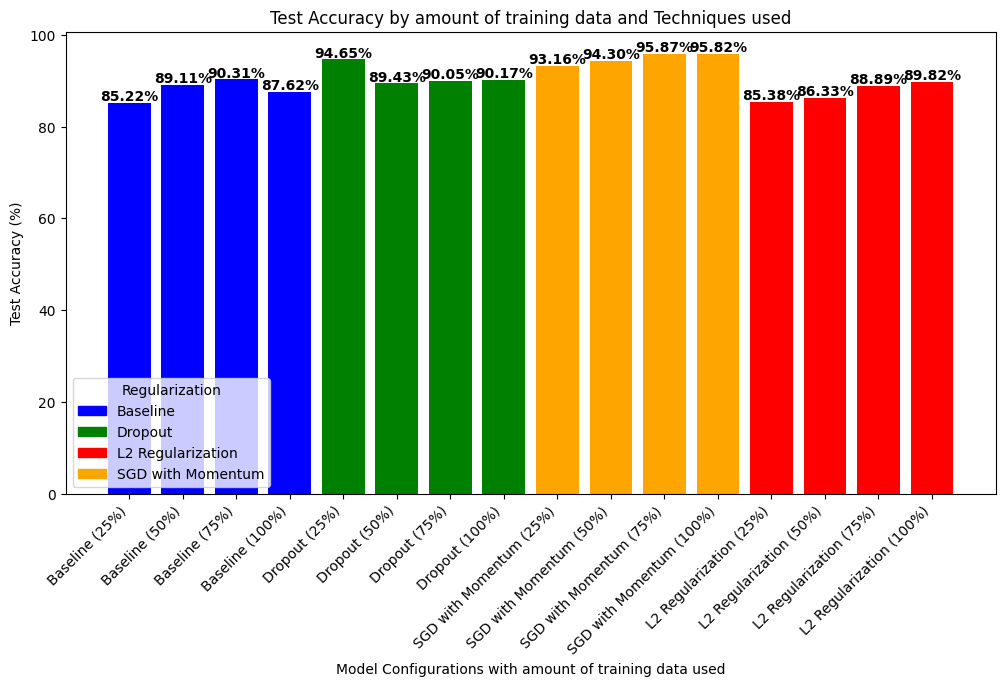

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy values obtained from above testing 
accuracy_values = [85.22, 89.11, 90.31,87.62,94.65, 89.43, 90.05, 90.17, 93.16, 94.30, 95.87, 95.82, 85.38, 86.33, 88.89, 89.82]
configurations = [
    "Baseline (25%)", 
    "Baseline (50%)", 
    "Baseline (75%)", 
    "Baseline (100%)",
    "Dropout (25%)", 
    "Dropout (50%)", 
    "Dropout (75%)", 
    "Dropout (100%)",
    "SGD with Momentum (25%)", 
    "SGD with Momentum (50%)", 
    "SGD with Momentum (75%)", 
    "SGD with Momentum (100%)", 
    "L2 Regularization (25%)", 
    "L2 Regularization (50%)", 
    "L2 Regularization (75%)", 
    "L2 Regularization (100%)"
]

# Assigning the  regularization techniques based on the configuration names
Techniques = []
for config in configurations:
    if "Dropout" in config:
        Techniques.append("Dropout")
    elif "L2 Regularization" in config:
        Techniques.append("L2 Regularization")
    elif "SGD with Momentum" in config:
        Techniques.append("SGD with Momentum")
    else:
        Techniques.append("Baseline")

# Creating the DataFrame for visualization
accuracy_df = pd.DataFrame({
    "Configuration": configurations,
    "Test Accuracy (%)": accuracy_values,
    "Regularization": Techniques
})

# Generating the bar chart
plt.figure(figsize=(12, 6))
colors = {
    "Baseline": "blue",
    "Dropout": "green",
    "L2 Regularization": "red",
    "SGD with Momentum": "orange"
}
colors = [colors[reg] for reg in accuracy_df["Regularization"]]

#plt.bar(accuracy_df["Configuration"], accuracy_df["Test Accuracy (%)"], color=colors)

# Creating the  bars
bars = plt.bar(accuracy_df["Configuration"], accuracy_df["Test Accuracy (%)"], color=colors)

# Adding values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}%", ha='center', fontsize=10, fontweight='bold')


plt.xlabel("Model Configurations with amount of training data used")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy by amount of training data and Techniques used")
plt.xticks(range(len(configurations)), configurations, rotation=45, ha="right")

# Legend
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color="blue", label="Baseline"),
    plt.Rectangle((0,0),1,1, color="green", label="Dropout"),
    plt.Rectangle((0,0),1,1, color="red", label="L2 Regularization"),
    plt.Rectangle((0,0),1,1, color="orange", label="SGD with Momentum")
], title="Regularization")

plt.show()
